# False Positive Disutility Sensitivity Analysis

This notebook runs the glaucoma model analysis **three times** with different disutility values for false positive screening results:

1. **No disutility scenario**: No disutility for false positives (base case)
2. **Low disutility scenario**: 0.01 disutility for 1 year for false positives
3. **High disutility scenario**: 0.05 disutility for 1 year for false positives

The analysis compares AI-enhanced vs traditional glaucoma screening across all three disutility scenarios.

---

### 📊 Analysis Setup

**False Positive Rate**: Based on AI screening specificity and prevalence
- False positive proportion = (1 - prevalence) × (1 - specificity) / [(1 - prevalence) × (1 - specificity) + prevalence × sensitivity]
- These individuals experience disutility for 1 year following the false positive result

**Impact**: False positives reduce QALYs in the AI arm, making it less favorable compared to traditional screening.

All other parameters remain constant across scenarios - only the false positive disutility varies.

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy

sys.path.append('../src') 

from glaucoma_model.utils import (
    save_scenario_results
)
from glaucoma_model.analysis import (
    comprehensive_cost_effectiveness_analysis,
    create_summary_table
)

from glaucoma_model.parameters import (
    Parameter,
    GlaucomaParameters
)

from glaucoma_model.model import (
    BaseGlaucomaModel,
    AIGlaucomaModel,
    NonAIGlaucomaModel
)

from glaucoma_model.analysis import *

print("✓ Imports complete")

Parameter class defined!
Enhanced GlaucomaParameters class defined with state-specific screening accuracy, mortality odds ratios, and false positive disutility!
Enhanced models with age-dependent mortality from life tables defined!
✓ Imports complete


## Configuration

In [2]:
# Analysis parameters
N_ITERATIONS = 5000
YEARS = 30
STARTING_AGE = 61
MALE_PROPORTION = 0.55
RANDOM_SEED = 42

# Define THREE false positive disutility scenarios
fp_disutilities = {
    'None': 0.0,     # No disutility (base case)
    'Low': 0.01,     # Low disutility
    'High': 0.05     # High disutility
}

print("=== FALSE POSITIVE DISUTILITY SCENARIOS ===")
print(f"Scenario 1 (None): Disutility = {fp_disutilities['None']} (no FP impact on QALYs)")
print(f"Scenario 2 (Low): Disutility = {fp_disutilities['Low']} for 1 year")
print(f"Scenario 3 (High): Disutility = {fp_disutilities['High']} for 1 year")
print(f"\nAll scenarios use {N_ITERATIONS} iterations over {YEARS} years")
print(f"Starting age: {STARTING_AGE} years")

=== FALSE POSITIVE DISUTILITY SCENARIOS ===
Scenario 1 (None): Disutility = 0.0 (no FP impact on QALYs)
Scenario 2 (Low): Disutility = 0.01 for 1 year
Scenario 3 (High): Disutility = 0.05 for 1 year

All scenarios use 5000 iterations over 30 years
Starting age: 61 years


## Calculate False Positive Rate

Determine the proportion of screened individuals who will be false positives

In [3]:
# Create temporary model to get screening parameters
temp_model = AIGlaucomaModel()

sensitivity = temp_model.params.screening_accuracy['sensitivity'].mean
specificity = temp_model.params.screening_accuracy['specificity'].mean
prevalence = temp_model.params.screening_params['prevalence_general'].mean

# Calculate false positive rate
# FP rate among screened = (1-prev) × (1-spec) / total positive tests
# Total positive tests = prev × sens + (1-prev) × (1-spec)
true_positives = prevalence * sensitivity
false_positives = (1 - prevalence) * (1 - specificity)
total_positives = true_positives + false_positives
fp_proportion = false_positives / total_positives if total_positives > 0 else 0

# Among all screened people
fp_rate_overall = false_positives

print("=== FALSE POSITIVE CALCULATIONS ===")
print(f"\nScreening Parameters:")
print(f"  Sensitivity: {sensitivity:.1%}")
print(f"  Specificity: {specificity:.1%}")
print(f"  Prevalence: {prevalence:.2%}")
print(f"\nFalse Positive Rates:")
print(f"  FP among all screened: {fp_rate_overall:.2%}")
print(f"  FP among positive tests: {fp_proportion:.2%}")
print(f"\nFor every 1,000 people screened:")
print(f"  True positives: {true_positives * 1000:.1f}")
print(f"  False positives: {false_positives * 1000:.1f}")
print(f"  True negatives: {(1 - prevalence) * specificity * 1000:.1f}")
print(f"  False negatives: {prevalence * (1 - sensitivity) * 1000:.1f}")

=== FALSE POSITIVE CALCULATIONS ===

Screening Parameters:
  Sensitivity: 77.5%
  Specificity: 95.4%
  Prevalence: 5.00%

False Positive Rates:
  FP among all screened: 4.37%
  FP among positive tests: 53.00%

For every 1,000 people screened:
  True positives: 38.8
  False positives: 43.7
  True negatives: 906.3
  False negatives: 11.2


## Define Helper Function

This function runs the complete analysis for a single false positive disutility value.

In [4]:
def run_single_scenario(fp_disutility, scenario_name):
    """
    Run the complete analysis for a single false positive disutility
    
    Parameters:
    -----------
    fp_disutility : float
        The disutility value for false positives (0.0 to 0.05)
    scenario_name : str
        Name for this scenario
    
    Returns:
    --------
    dict : Results including summary table and comprehensive results
    """
    print(f"\n{'='*80}")
    print(f"SCENARIO: {scenario_name}")
    print(f"False Positive Disutility: {fp_disutility} (applied for 1 year)")
    print(f"{'='*80}\n")
    
    # Initialize models
    model_ai = AIGlaucomaModel(starting_age=STARTING_AGE)
    model_ai.load_mortality_table_from_file(
        filepath_male='../data/male_mortality_2023.csv',
        filepath_female='../data/female_mortality_2023.csv',
        male_proportion=MALE_PROPORTION
    )
    
    model_non_ai = NonAIGlaucomaModel(starting_age=STARTING_AGE)
    model_non_ai.load_mortality_table_from_file(
        filepath_male='../data/male_mortality_2023.csv',
        filepath_female='../data/female_mortality_2023.csv',
        male_proportion=MALE_PROPORTION
    )
    
    # Initial distribution (fixed proportions: 38 mild, 9 moderate, 7 severe, 0 VI, 0 dead)
    initial_dist = [38, 9, 7, 0, 0]
    initial_dist = np.array(initial_dist) / np.sum(initial_dist)
    
    # Run AI PSA
    print(f"Running AI Model PSA ({N_ITERATIONS} iterations)...")
    ai_psa_results = model_ai.run_probabilistic(
        n_iterations=N_ITERATIONS,
        initial_dist=initial_dist,
        years=YEARS,
        include_screening=True,
        population_type='general',
        random_seed=RANDOM_SEED,
        return_traces=True
    )
    
    # Run Non-AI PSA
    print(f"Running Non-AI Model PSA ({N_ITERATIONS} iterations)...")
    non_ai_psa_results = model_non_ai.run_probabilistic(
        n_iterations=N_ITERATIONS,
        initial_dist=initial_dist,
        years=YEARS,
        include_screening=True,
        population_type='general',
        random_seed=RANDOM_SEED,
        return_traces=True
    )
    
    # Adjust for sensitivity and specificity
    print("Adjusting for sensitivity and specificity...")
    ai_traces = ai_psa_results['trace_tensor']
    non_ai_traces = non_ai_psa_results['trace_tensor']
    variable_names = ai_psa_results['trace_variable_names']
    
    ai_eff0_psa_traces = copy.deepcopy(ai_traces)
    ai_eff0_psa_results = copy.deepcopy(ai_psa_results)
    
    sensitivity_value = model_ai.params.screening_accuracy['sensitivity'].mean
    specificity_value = model_ai.params.screening_accuracy['specificity'].mean
    prevalence_value = model_ai.params.screening_params['prevalence_general'].mean
    
    # Adjust costs
    for var_name in ['Total_Cost', 'Total_Cost_Disc']:
        if var_name in variable_names:
            var_idx = variable_names.index(var_name)
            ai_eff0_psa_traces[:, :, var_idx] = (
                sensitivity_value * ai_traces[:, :, var_idx] +
                (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
            )
    
    # Adjust QALYs
    qaly_vars = ['Total_QALY', 'Total_QALY_Disc', 'QALY_Mild', 'QALY_Moderate', 'QALY_Severe', 'QALY_VI']
    for var_name in qaly_vars:
        if var_name in variable_names:
            var_idx = variable_names.index(var_name)
            ai_eff0_psa_traces[:, :, var_idx] = (
                sensitivity_value * ai_traces[:, :, var_idx] +
                (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
            )
    
    ai_eff0_psa_results['trace_tensor'] = ai_eff0_psa_traces
    
    # Add screening costs
    idx1 = variable_names.index('Total_Cost')
    idx2 = variable_names.index('Total_Cost_Disc')
    
    ai_screening_cost = model_ai.params.costs['ai_screening'].mean
    human_screening_cost = model_ai.params.costs['human_screening'].mean
    
    # AI screening costs
    ai_screening_per_case = (1/prevalence_value) * ai_screening_cost
    ai_eff0_psa_results['trace_tensor'][:, 0, idx1] += ai_screening_per_case
    ai_eff0_psa_results['trace_tensor'][:, 0, idx2] += ai_screening_per_case
    
    # False positive costs
    false_positives_per_case = ((1 - prevalence_value) / prevalence_value) * (1 - specificity_value)
    ai_eff0_psa_results['trace_tensor'][:, 0, idx1] += false_positives_per_case * human_screening_cost
    ai_eff0_psa_results['trace_tensor'][:, 0, idx2] += false_positives_per_case * human_screening_cost
    
    # =========================================================================
    # APPLY FALSE POSITIVE DISUTILITY - THIS IS THE KEY STEP
    # =========================================================================
    if fp_disutility > 0:
        print(f"Applying false positive disutility of {fp_disutility} for year 0...")
        
        # Calculate the false positive rate among screened population
        # FP occur in the AI screening arm among those without disease
        fp_rate = (1 - prevalence_value) * (1 - specificity_value)
        
        # QALY loss from false positives
        # Each FP person loses fp_disutility QALYs for 1 year (year 0)
        qaly_loss_per_screened = fp_rate * fp_disutility
        
        # Get discount rate for QALYs
        health_discount_rate = model_ai.params.discount_rates['health_discount'].mean
        
        # Apply disutility to year 0 (undiscounted and discounted)
        idx_qaly = variable_names.index('Total_QALY')
        idx_qaly_disc = variable_names.index('Total_QALY_Disc')
        
        # Subtract QALY loss from AI arm
        ai_eff0_psa_results['trace_tensor'][:, 0, idx_qaly] -= qaly_loss_per_screened
        ai_eff0_psa_results['trace_tensor'][:, 0, idx_qaly_disc] -= qaly_loss_per_screened  # Year 0, no discount needed
        
        print(f"  False positive rate: {fp_rate:.2%}")
        print(f"  QALY loss per screened person: {qaly_loss_per_screened:.5f}")
        print(f"  Total QALY loss for year 0: {qaly_loss_per_screened:.5f} QALYs")
    
    # Run comprehensive analysis
    print("Running comprehensive cost-effectiveness analysis...")
    comprehensive_results = comprehensive_cost_effectiveness_analysis(
        ai_eff0_psa_results, non_ai_psa_results,
        time_horizons=[5, 10, 15, 20, 30],
        thresholds=[0, 20000, 50000, 75000, 100000, 150000, 200000],
        confidence_level=0.95,
        discounted=True
    )
    
    summary_table = create_summary_table(comprehensive_results)
    
    return {
        'scenario_name': scenario_name,
        'fp_disutility': fp_disutility,
        'fp_rate': fp_rate if fp_disutility > 0 else 0,
        'qaly_loss_per_screened': qaly_loss_per_screened if fp_disutility > 0 else 0,
        'comprehensive_results': comprehensive_results,
        'summary_table': summary_table,
        'ai_psa_results': ai_psa_results,
        'non_ai_psa_results': non_ai_psa_results,
        'ai_eff0_psa_results': ai_eff0_psa_results
    }

print("✓ Helper function defined")

✓ Helper function defined


## Scenario 1: No False Positive Disutility

Running analysis with no disutility for false positives (base case)

In [5]:
results_none = run_single_scenario(
    fp_disutility=fp_disutilities['None'],
    scenario_name="No FP Disutility"
)


SCENARIO: No FP Disutility
False Positive Disutility: 0.0 (applied for 1 year)

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model

### Summary Table - No Disutility

In [6]:
print("\n=== NO FP DISUTILITY SCENARIO - SUMMARY TABLE ===")
print(results_none['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_none['summary_table'])


=== NO FP DISUTILITY SCENARIO - SUMMARY TABLE ===
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI     ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                  €817     [€-1,902, €3,569]                 0.070       [-0.192, 0.328]  €11,637    €2,949      €1,766 [€-149,461, €133,426]       64.7%       76.9%        81.3%
    10 years               €-1,315     [€-7,939, €4,944]                 0.222       [-0.358, 0.789]  €-5,916   €-2,122     €-3,124 [€-127,559, €123,218]       83.3%       87.9%        89.3%
    15 years               €-5,026    [€-16,283, €5,305]                 0.423       [-0.532, 1.352] €-11,881   €-6,588     €-6,380 [€-113,390, €106,677]       91.6%       93.4%        94.1%
    20 years               €-8,810    [€-24,369, €5,242]                 0.642       [-0.686, 1.914] €-13,718   €-9,271     €-8,493  [€-117,168, €98,760]       95.0%       95.8%        

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,€817,"[€-1,902, €3,569]",0.070,"[-0.192, 0.328]","€11,637","€2,949","€1,766","[€-149,461, €133,426]",64.7%,76.9%,81.3%
1,10 years,"€-1,315","[€-7,939, €4,944]",0.222,"[-0.358, 0.789]","€-5,916","€-2,122","€-3,124","[€-127,559, €123,218]",83.3%,87.9%,89.3%
2,15 years,"€-5,026","[€-16,283, €5,305]",0.423,"[-0.532, 1.352]","€-11,881","€-6,588","€-6,380","[€-113,390, €106,677]",91.6%,93.4%,94.1%
3,20 years,"€-8,810","[€-24,369, €5,242]",0.642,"[-0.686, 1.914]","€-13,718","€-9,271","€-8,493","[€-117,168, €98,760]",95.0%,95.8%,96.0%
4,30 years,"€-11,683","[€-30,396, €5,448]",0.955,"[-0.772, 2.581]","€-12,237","€-10,457","€-8,863","[€-105,881, €81,338]",96.6%,97.1%,97.2%


### Key Results - No Disutility

In [7]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (No FP Disutility) ===")
    results = results_none['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (No FP Disutility) ===
ICER (95% CI): €2,949 [-149,461, 133,426]
Incremental Cost: €817
Incremental QALY: 0.070
Probability cost-effective at €20k/QALY: 64.7%
Probability cost-effective at €50k/QALY: 76.9%
Probability cost-effective at €100k/QALY: 81.3%

=== 10-YEAR RESULTS (No FP Disutility) ===
ICER (95% CI): €-2,122 [-127,559, 123,218]
Incremental Cost: €-1,315
Incremental QALY: 0.222
Probability cost-effective at €20k/QALY: 83.3%
Probability cost-effective at €50k/QALY: 87.9%
Probability cost-effective at €100k/QALY: 89.3%

=== 30-YEAR RESULTS (No FP Disutility) ===
ICER (95% CI): €-10,457 [-105,881, 81,338]
Incremental Cost: €-11,683
Incremental QALY: 0.955
Probability cost-effective at €20k/QALY: 96.6%
Probability cost-effective at €50k/QALY: 97.1%
Probability cost-effective at €100k/QALY: 97.2%


### Save No Disutility Results

In [8]:
results_none['summary_table'].to_csv('../data/fp_disutility_none_summary.csv', index=False)
print("✓ No FP disutility scenario results saved to ../data/fp_disutility_none_summary.csv")

✓ No FP disutility scenario results saved to ../data/fp_disutility_none_summary.csv


## Scenario 2: Low False Positive Disutility (0.01)

Running analysis with 0.01 disutility for false positives

In [9]:
results_low = run_single_scenario(
    fp_disutility=fp_disutilities['Low'],
    scenario_name="Low FP Disutility (0.01)"
)


SCENARIO: Low FP Disutility (0.01)
False Positive Disutility: 0.01 (applied for 1 year)

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
 

### Summary Table - Low Disutility

In [10]:
print("\n=== LOW FP DISUTILITY SCENARIO - SUMMARY TABLE ===")
print(results_low['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_low['summary_table'])


=== LOW FP DISUTILITY SCENARIO - SUMMARY TABLE ===
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI     ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                  €817     [€-1,902, €3,569]                 0.070       [-0.192, 0.327]  €11,706    €3,392      €1,816 [€-148,666, €138,551]       64.7%       76.8%        81.2%
    10 years               €-1,315     [€-7,938, €4,932]                 0.222       [-0.358, 0.788]  €-5,931   €-2,308     €-3,127 [€-128,704, €120,301]       83.3%       87.9%        89.3%
    15 years               €-5,026    [€-16,282, €5,305]                 0.422       [-0.532, 1.351] €-11,898   €-6,613     €-6,373 [€-114,367, €107,879]       91.6%       93.4%        94.1%
    20 years               €-8,809    [€-24,369, €5,242]                 0.642       [-0.687, 1.913] €-13,725   €-9,066     €-8,495  [€-115,817, €99,333]       95.0%       95.8%       

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,€817,"[€-1,902, €3,569]",0.070,"[-0.192, 0.327]","€11,706","€3,392","€1,816","[€-148,666, €138,551]",64.7%,76.8%,81.2%
1,10 years,"€-1,315","[€-7,938, €4,932]",0.222,"[-0.358, 0.788]","€-5,931","€-2,308","€-3,127","[€-128,704, €120,301]",83.3%,87.9%,89.3%
2,15 years,"€-5,026","[€-16,282, €5,305]",0.422,"[-0.532, 1.351]","€-11,898","€-6,613","€-6,373","[€-114,367, €107,879]",91.6%,93.4%,94.1%
3,20 years,"€-8,809","[€-24,369, €5,242]",0.642,"[-0.687, 1.913]","€-13,725","€-9,066","€-8,495","[€-115,817, €99,333]",95.0%,95.8%,96.0%
4,30 years,"€-11,683","[€-30,396, €5,448]",0.954,"[-0.773, 2.580]","€-12,242","€-10,525","€-8,866","[€-106,151, €80,815]",96.6%,97.1%,97.2%


### Key Results - Low Disutility

In [11]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (Low FP Disutility) ===")
    results = results_low['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (Low FP Disutility) ===
ICER (95% CI): €3,392 [-148,666, 138,551]
Incremental Cost: €817
Incremental QALY: 0.070
Probability cost-effective at €20k/QALY: 64.7%
Probability cost-effective at €50k/QALY: 76.8%
Probability cost-effective at €100k/QALY: 81.2%

=== 10-YEAR RESULTS (Low FP Disutility) ===
ICER (95% CI): €-2,308 [-128,704, 120,301]
Incremental Cost: €-1,315
Incremental QALY: 0.222
Probability cost-effective at €20k/QALY: 83.3%
Probability cost-effective at €50k/QALY: 87.9%
Probability cost-effective at €100k/QALY: 89.3%

=== 30-YEAR RESULTS (Low FP Disutility) ===
ICER (95% CI): €-10,525 [-106,151, 80,815]
Incremental Cost: €-11,683
Incremental QALY: 0.954
Probability cost-effective at €20k/QALY: 96.6%
Probability cost-effective at €50k/QALY: 97.1%
Probability cost-effective at €100k/QALY: 97.2%


### Save Low Disutility Results

In [12]:
results_low['summary_table'].to_csv('../data/fp_disutility_low_summary.csv', index=False)
print("✓ Low FP disutility scenario results saved to ../data/fp_disutility_low_summary.csv")

✓ Low FP disutility scenario results saved to ../data/fp_disutility_low_summary.csv


## Scenario 3: High False Positive Disutility (0.05)

Running analysis with 0.05 disutility for false positives

In [13]:
results_high = run_single_scenario(
    fp_disutility=fp_disutilities['High'],
    scenario_name="High FP Disutility (0.05)"
)


SCENARIO: High FP Disutility (0.05)
False Positive Disutility: 0.05 (applied for 1 year)

Applied Non-AI cost structure: Only VI patients incur costs
Running AI Model PSA (5000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000


### Summary Table - High Disutility

In [14]:
print("\n=== HIGH FP DISUTILITY SCENARIO - SUMMARY TABLE ===")
print(results_high['summary_table'].to_string(index=False))

# Display as DataFrame for better formatting
display(results_high['summary_table'])


=== HIGH FP DISUTILITY SCENARIO - SUMMARY TABLE ===
Time_Horizon Incremental_Cost_Mean Incremental_Cost_95CI Incremental_QALY_Mean Incremental_QALY_95CI     ICER ICER_Mean ICER_Median             ICER_95CI Prob_CE_20k Prob_CE_50k Prob_CE_100k
     5 years                  €817     [€-1,904, €3,568]                 0.068       [-0.194, 0.326]  €11,994    €3,489      €1,776 [€-142,679, €143,060]       64.5%       76.6%        80.9%
    10 years               €-1,324     [€-7,940, €4,927]                 0.220       [-0.360, 0.787]  €-6,012   €-2,238     €-3,078 [€-127,043, €122,887]       83.3%       87.9%        89.3%
    15 years               €-5,023    [€-16,278, €5,305]                 0.420       [-0.533, 1.349] €-11,950   €-6,546     €-6,351 [€-113,951, €112,789]       91.5%       93.4%        94.0%
    20 years               €-8,800    [€-24,365, €5,253]                 0.639       [-0.688, 1.911] €-13,765   €-9,052     €-8,465  [€-118,246, €98,658]       94.9%       95.8%      

,Time_Horizon,Incremental_Cost_Mean,Incremental_Cost_95CI,Incremental_QALY_Mean,Incremental_QALY_95CI,ICER,ICER_Mean,ICER_Median,ICER_95CI,Prob_CE_20k,Prob_CE_50k,Prob_CE_100k
0,5 years,€817,"[€-1,904, €3,568]",0.068,"[-0.194, 0.326]","€11,994","€3,489","€1,776","[€-142,679, €143,060]",64.5%,76.6%,80.9%
1,10 years,"€-1,324","[€-7,940, €4,927]",0.220,"[-0.360, 0.787]","€-6,012","€-2,238","€-3,078","[€-127,043, €122,887]",83.3%,87.9%,89.3%
2,15 years,"€-5,023","[€-16,278, €5,305]",0.420,"[-0.533, 1.349]","€-11,950","€-6,546","€-6,351","[€-113,951, €112,789]",91.5%,93.4%,94.0%
3,20 years,"€-8,800","[€-24,365, €5,253]",0.639,"[-0.688, 1.911]","€-13,765","€-9,052","€-8,465","[€-118,246, €98,658]",94.9%,95.8%,96.0%
4,30 years,"€-11,681","[€-30,396, €5,448]",0.953,"[-0.774, 2.578]","€-12,260","€-10,284","€-8,872","[€-105,268, €82,653]",96.6%,97.1%,97.2%


### Key Results - High Disutility

In [15]:
for years in [5, 10, 30]:
    print(f"\n=== {years}-YEAR RESULTS (High FP Disutility) ===")
    results = results_high['comprehensive_results'][f'{years}_years']['summary']
    print(f"ICER (95% CI): €{results['icer_mean']:,.0f} [{results['icer_ci'][0]:,.0f}, {results['icer_ci'][1]:,.0f}]")
    print(f"Incremental Cost: €{results['incremental_cost_mean']:,.0f}")
    print(f"Incremental QALY: {results['incremental_qaly_mean']:.3f}")
    print(f"Probability cost-effective at €20k/QALY: {results['prob_cost_effective_20k']:.1f}%")
    print(f"Probability cost-effective at €50k/QALY: {results['prob_cost_effective_50k']:.1f}%")
    print(f"Probability cost-effective at €100k/QALY: {results['prob_cost_effective_100k']:.1f}%")


=== 5-YEAR RESULTS (High FP Disutility) ===
ICER (95% CI): €3,489 [-142,679, 143,060]
Incremental Cost: €817
Incremental QALY: 0.068
Probability cost-effective at €20k/QALY: 64.5%
Probability cost-effective at €50k/QALY: 76.6%
Probability cost-effective at €100k/QALY: 80.9%

=== 10-YEAR RESULTS (High FP Disutility) ===
ICER (95% CI): €-2,238 [-127,043, 122,887]
Incremental Cost: €-1,324
Incremental QALY: 0.220
Probability cost-effective at €20k/QALY: 83.3%
Probability cost-effective at €50k/QALY: 87.9%
Probability cost-effective at €100k/QALY: 89.3%

=== 30-YEAR RESULTS (High FP Disutility) ===
ICER (95% CI): €-10,284 [-105,268, 82,653]
Incremental Cost: €-11,681
Incremental QALY: 0.953
Probability cost-effective at €20k/QALY: 96.6%
Probability cost-effective at €50k/QALY: 97.1%
Probability cost-effective at €100k/QALY: 97.2%


### Save High Disutility Results

In [16]:
results_high['summary_table'].to_csv('../data/fp_disutility_high_summary.csv', index=False)
print("✓ High FP disutility scenario results saved to ../data/fp_disutility_high_summary.csv")

✓ High FP disutility scenario results saved to ../data/fp_disutility_high_summary.csv


## Comparison of Scenarios

Direct comparison of all three false positive disutility scenarios

In [17]:
print("\n" + "="*80)
print("COMPARISON OF SCENARIOS")
print("="*80)

print(f"\nScenario 1 (None): FP Disutility = {results_none['fp_disutility']}")
print(f"Scenario 2 (Low): FP Disutility = {results_low['fp_disutility']} for 1 year")
print(f"Scenario 3 (High): FP Disutility = {results_high['fp_disutility']} for 1 year")

if results_low['qaly_loss_per_screened'] > 0:
    print(f"\nQALY Impact per Screened Person:")
    print(f"  Low disutility: {results_low['qaly_loss_per_screened']:.5f} QALYs lost")
    print(f"  High disutility: {results_high['qaly_loss_per_screened']:.5f} QALYs lost")


COMPARISON OF SCENARIOS

Scenario 1 (None): FP Disutility = 0.0
Scenario 2 (Low): FP Disutility = 0.01 for 1 year
Scenario 3 (High): FP Disutility = 0.05 for 1 year

QALY Impact per Screened Person:
  Low disutility: 0.00044 QALYs lost
  High disutility: 0.00219 QALYs lost


### 10-Year ICER Comparison

In [18]:
print("\n=== 10-YEAR ICER COMPARISON ===")
print("-" * 80)

res_none = results_none['comprehensive_results']['10_years']['summary']
res_low = results_low['comprehensive_results']['10_years']['summary']
res_high = results_high['comprehensive_results']['10_years']['summary']

print(f"\nNo FP Disutility:")
print(f"  ICER: €{res_none['icer_mean']:,.0f}")
print(f"  Incremental Cost: €{res_none['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_none['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_none['prob_cost_effective_50k']:.1f}%")

print(f"\nLow FP Disutility (0.01):")
print(f"  ICER: €{res_low['icer_mean']:,.0f}")
print(f"  Incremental Cost: €{res_low['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_low['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_low['prob_cost_effective_50k']:.1f}%")

print(f"\nHigh FP Disutility (0.05):")
print(f"  ICER: €{res_high['icer_mean']:,.0f}")
print(f"  Incremental Cost: €{res_high['incremental_cost_mean']:,.0f}")
print(f"  Incremental QALY: {res_high['incremental_qaly_mean']:.3f}")
print(f"  Prob CE at €50k: {res_high['prob_cost_effective_50k']:.1f}%")

print(f"\nDifferences (None vs High):")
print(f"  ΔICER: €{res_high['icer_mean'] - res_none['icer_mean']:,.0f}")
print(f"  ΔIncremental QALY: {res_high['incremental_qaly_mean'] - res_none['incremental_qaly_mean']:.3f}")
print(f"  ΔProb CE at €50k: {res_high['prob_cost_effective_50k'] - res_none['prob_cost_effective_50k']:.1f} percentage points")


=== 10-YEAR ICER COMPARISON ===
--------------------------------------------------------------------------------

No FP Disutility:
  ICER: €-2,122
  Incremental Cost: €-1,315
  Incremental QALY: 0.222
  Prob CE at €50k: 87.9%

Low FP Disutility (0.01):
  ICER: €-2,308
  Incremental Cost: €-1,315
  Incremental QALY: 0.222
  Prob CE at €50k: 87.9%

High FP Disutility (0.05):
  ICER: €-2,238
  Incremental Cost: €-1,324
  Incremental QALY: 0.220
  Prob CE at €50k: 87.9%

Differences (None vs High):
  ΔICER: €-116
  ΔIncremental QALY: -0.002
  ΔProb CE at €50k: -0.0 percentage points


### Comparison Table

In [19]:
# Create comparison dataframe
comparison_data = []

for time_horizon in [5, 10, 15, 20, 30]:
    res_none = results_none['comprehensive_results'][f'{time_horizon}_years']['summary']
    res_low = results_low['comprehensive_results'][f'{time_horizon}_years']['summary']
    res_high = results_high['comprehensive_results'][f'{time_horizon}_years']['summary']
    
    comparison_data.append({
        'Time_Horizon': f'{time_horizon} years',
        'ICER_None': res_none['icer_mean'],
        'ICER_Low': res_low['icer_mean'],
        'ICER_High': res_high['icer_mean'],
        'IncCost_None': res_none['incremental_cost_mean'],
        'IncCost_Low': res_low['incremental_cost_mean'],
        'IncCost_High': res_high['incremental_cost_mean'],
        'IncQALY_None': res_none['incremental_qaly_mean'],
        'IncQALY_Low': res_low['incremental_qaly_mean'],
        'IncQALY_High': res_high['incremental_qaly_mean'],
        'ProbCE50k_None': res_none['prob_cost_effective_50k'],
        'ProbCE50k_Low': res_low['prob_cost_effective_50k'],
        'ProbCE50k_High': res_high['prob_cost_effective_50k']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\n=== COMPARISON TABLE ACROSS ALL TIME HORIZONS ===")
display(comparison_df)

# Save comparison table
comparison_df.to_csv('../data/fp_disutility_comparison.csv', index=False)
print("\n✓ Comparison table saved to ../data/fp_disutility_comparison.csv")


=== COMPARISON TABLE ACROSS ALL TIME HORIZONS ===


,Time_Horizon,ICER_None,ICER_Low,ICER_High,IncCost_None,IncCost_Low,IncCost_High,IncQALY_None,IncQALY_Low,IncQALY_High,ProbCE50k_None,ProbCE50k_Low,ProbCE50k_High
0,5 years,2948.638954,3391.836002,3489.045184,817.326387,816.700463,816.826758,0.070237,0.069765,0.068101,76.871303,76.758410,76.557076
1,10 years,-2121.736128,-2308.258180,-2237.582121,-1315.028110,-1315.467594,-1323.511261,0.222267,0.221782,0.220143,87.900934,87.903389,87.896019
2,15 years,-6588.016722,-6612.605180,-6546.409205,-5025.634944,-5026.441908,-5023.270719,0.422980,0.422454,0.420342,93.407935,93.409276,93.353659
3,20 years,-9270.929037,-9066.489693,-9052.002350,-8809.632640,-8809.490224,-8800.420530,0.642193,0.641878,0.639313,95.813008,95.812157,95.756345
4,30 years,-10457.237151,-10525.428791,-10284.187416,-11682.978059,-11682.978059,-11680.633200,0.954758,0.954321,0.952736,97.104677,97.104677,97.063588



✓ Comparison table saved to ../data/fp_disutility_comparison.csv


## Visualizations

### ICER Comparison Across Time Horizons

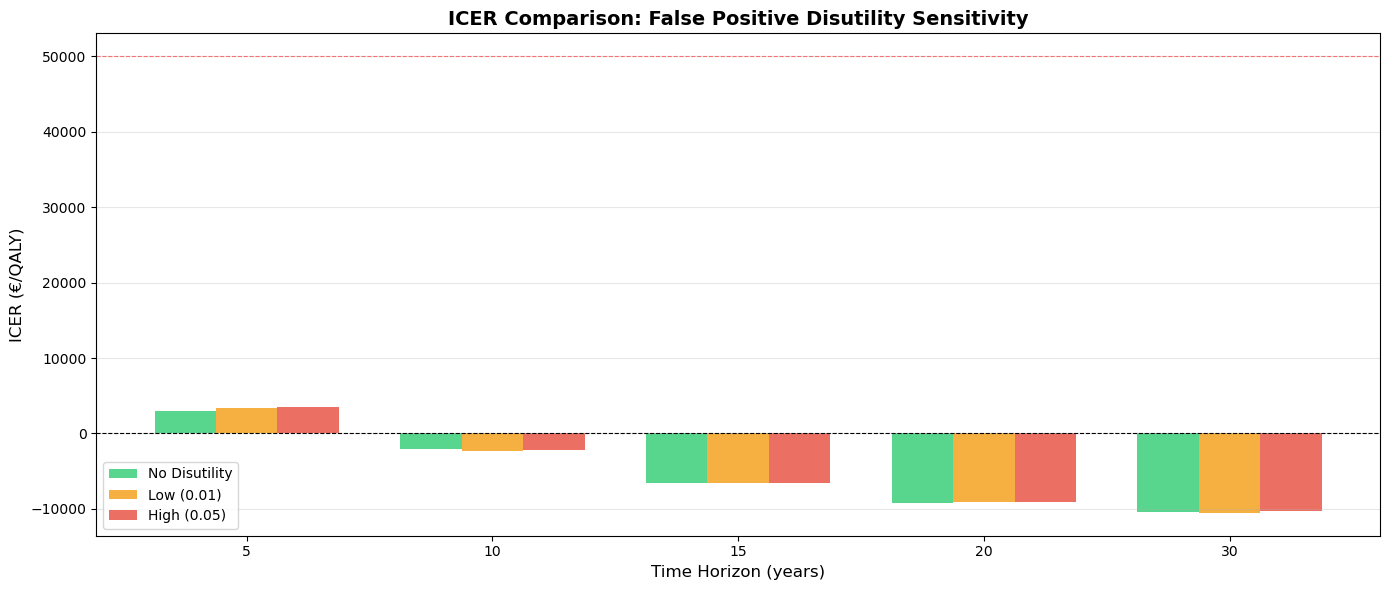

✓ ICER comparison plot saved to ../data/fp_disutility_icer_comparison.png


In [20]:
fig, ax = plt.subplots(figsize=(14, 6))

time_horizons = [5, 10, 15, 20, 30]
icers_none = [results_none['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]
icers_low = [results_low['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]
icers_high = [results_high['comprehensive_results'][f'{t}_years']['summary']['icer_mean'] for t in time_horizons]

x = np.arange(len(time_horizons))
width = 0.25

bars1 = ax.bar(x - width, icers_none, width, label='No Disutility', alpha=0.8, color='#2ecc71')
bars2 = ax.bar(x, icers_low, width, label='Low (0.01)', alpha=0.8, color='#f39c12')
bars3 = ax.bar(x + width, icers_high, width, label='High (0.05)', alpha=0.8, color='#e74c3c')

ax.set_xlabel('Time Horizon (years)', fontsize=12)
ax.set_ylabel('ICER (€/QALY)', fontsize=12)
ax.set_title('ICER Comparison: False Positive Disutility Sensitivity', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(time_horizons)
ax.legend()
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
ax.axhline(y=50000, color='red', linestyle='--', linewidth=0.8, alpha=0.5, label='€50k threshold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/fp_disutility_icer_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ ICER comparison plot saved to ../data/fp_disutility_icer_comparison.png")

### Probability of Cost-Effectiveness Comparison

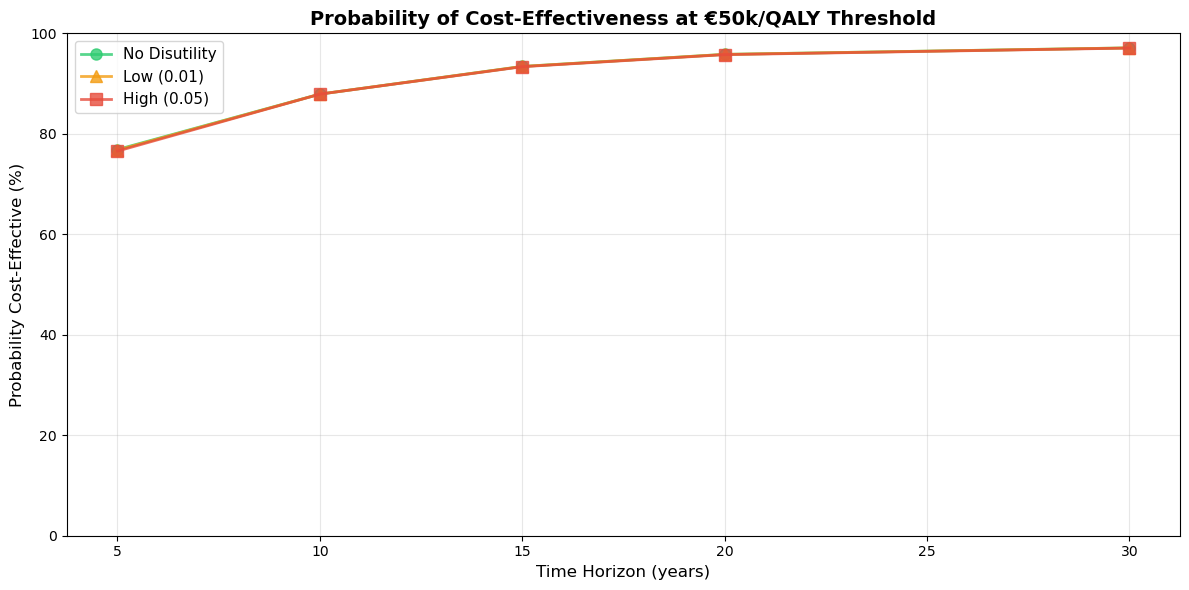

✓ Probability CE comparison plot saved to ../data/fp_disutility_prob_ce_comparison.png


In [21]:
fig, ax = plt.subplots(figsize=(12, 6))

prob_ce_none = [results_none['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]
prob_ce_low = [results_low['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]
prob_ce_high = [results_high['comprehensive_results'][f'{t}_years']['summary']['prob_cost_effective_50k'] for t in time_horizons]

ax.plot(time_horizons, prob_ce_none, marker='o', linewidth=2, markersize=8, label='No Disutility', alpha=0.8, color='#2ecc71')
ax.plot(time_horizons, prob_ce_low, marker='^', linewidth=2, markersize=8, label='Low (0.01)', alpha=0.8, color='#f39c12')
ax.plot(time_horizons, prob_ce_high, marker='s', linewidth=2, markersize=8, label='High (0.05)', alpha=0.8, color='#e74c3c')

ax.set_xlabel('Time Horizon (years)', fontsize=12)
ax.set_ylabel('Probability Cost-Effective (%)', fontsize=12)
ax.set_title('Probability of Cost-Effectiveness at €50k/QALY Threshold', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../data/fp_disutility_prob_ce_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Probability CE comparison plot saved to ../data/fp_disutility_prob_ce_comparison.png")

### Incremental QALYs by FP Disutility

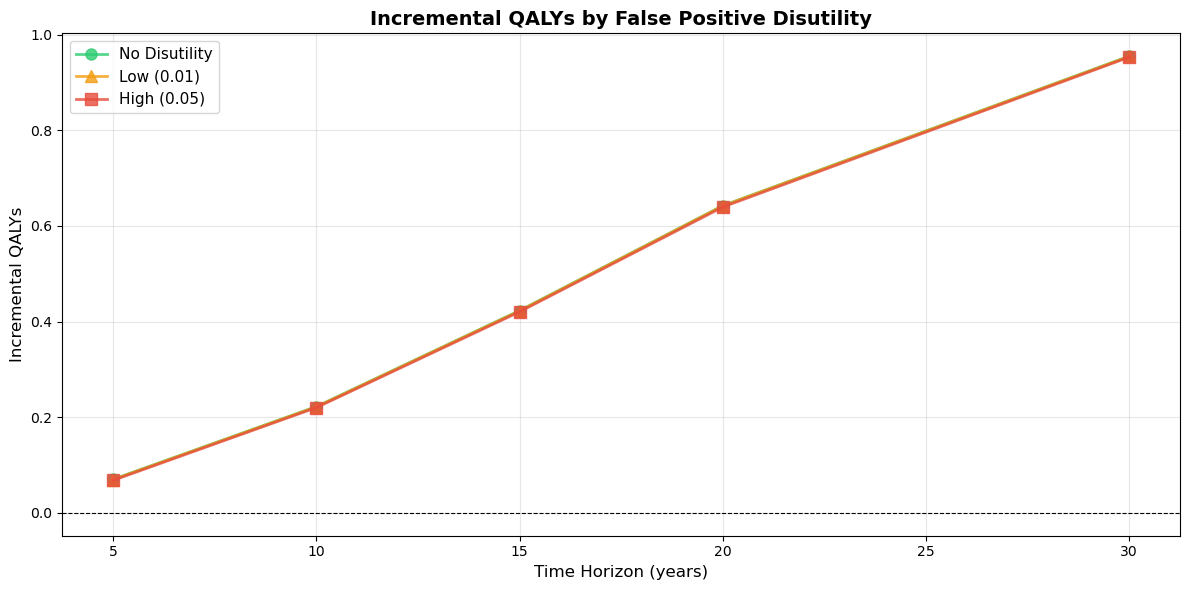

✓ QALYs comparison plot saved to ../data/fp_disutility_qalys_comparison.png


In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

qalys_none = [results_none['comprehensive_results'][f'{t}_years']['summary']['incremental_qaly_mean'] for t in time_horizons]
qalys_low = [results_low['comprehensive_results'][f'{t}_years']['summary']['incremental_qaly_mean'] for t in time_horizons]
qalys_high = [results_high['comprehensive_results'][f'{t}_years']['summary']['incremental_qaly_mean'] for t in time_horizons]

ax.plot(time_horizons, qalys_none, marker='o', linewidth=2, markersize=8, label='No Disutility', alpha=0.8, color='#2ecc71')
ax.plot(time_horizons, qalys_low, marker='^', linewidth=2, markersize=8, label='Low (0.01)', alpha=0.8, color='#f39c12')
ax.plot(time_horizons, qalys_high, marker='s', linewidth=2, markersize=8, label='High (0.05)', alpha=0.8, color='#e74c3c')

ax.set_xlabel('Time Horizon (years)', fontsize=12)
ax.set_ylabel('Incremental QALYs', fontsize=12)
ax.set_title('Incremental QALYs by False Positive Disutility', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.savefig('../data/fp_disutility_qalys_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ QALYs comparison plot saved to ../data/fp_disutility_qalys_comparison.png")

## Summary and Conclusions

In [24]:
print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

print("\n📊 Files saved:")
print("  - ../data/fp_disutility_none_summary.csv")
print("  - ../data/fp_disutility_low_summary.csv")
print("  - ../data/fp_disutility_high_summary.csv")
print("  - ../data/fp_disutility_comparison.csv")
print("  - ../data/fp_disutility_icer_comparison.png")
print("  - ../data/fp_disutility_prob_ce_comparison.png")
print("  - ../data/fp_disutility_qalys_comparison.png")

print("\n📈 Key Findings (10-year horizon):")
print(f"  No Disutility: ICER = €{res_none['icer_mean']:,.0f}/QALY, Inc QALYs = {res_none['incremental_qaly_mean']:.3f}")
print(f"  Low Disutility: ICER = €{res_low['icer_mean']:,.0f}/QALY, Inc QALYs = {res_low['incremental_qaly_mean']:.3f}")
print(f"  High Disutility: ICER = €{res_high['icer_mean']:,.0f}/QALY, Inc QALYs = {res_high['incremental_qaly_mean']:.3f}")

print("\n💡 Interpretation:")
qaly_loss_low = res_none['incremental_qaly_mean'] - res_low['incremental_qaly_mean']
qaly_loss_high = res_none['incremental_qaly_mean'] - res_high['incremental_qaly_mean']
icer_increase_low = res_low['icer_mean'] - res_none['icer_mean']
icer_increase_high = res_high['icer_mean'] - res_none['icer_mean']

print(f"  Low disutility (0.01) reduces incremental QALYs by {qaly_loss_low:.4f}")
print(f"  High disutility (0.05) reduces incremental QALYs by {qaly_loss_high:.4f}")
print(f"\n  Low disutility increases ICER by €{icer_increase_low:,.0f}/QALY")
print(f"  High disutility increases ICER by €{icer_increase_high:,.0f}/QALY")

print(f"\n📊 False Positive Impact:")
print(f"  False positive rate: {results_low['fp_rate']:.2%} of screened population")
print(f"  With low disutility: {results_low['qaly_loss_per_screened']:.5f} QALYs lost per screened person")
print(f"  With high disutility: {results_high['qaly_loss_per_screened']:.5f} QALYs lost per screened person")

if res_high['prob_cost_effective_50k'] > 70:
    print("\n  AI screening remains cost-effective even with high FP disutility.")
elif res_high['prob_cost_effective_50k'] < 50:
    print("\n  High FP disutility significantly impacts cost-effectiveness.")
else:
    print("\n  FP disutility has moderate impact on cost-effectiveness.")

print("\n✓ All three scenarios have been successfully analyzed and compared.")


ANALYSIS COMPLETE

📊 Files saved:
  - ../data/fp_disutility_none_summary.csv
  - ../data/fp_disutility_low_summary.csv
  - ../data/fp_disutility_high_summary.csv
  - ../data/fp_disutility_comparison.csv
  - ../data/fp_disutility_icer_comparison.png
  - ../data/fp_disutility_prob_ce_comparison.png
  - ../data/fp_disutility_qalys_comparison.png

📈 Key Findings (10-year horizon):
  No Disutility: ICER = €-10,457/QALY, Inc QALYs = 0.955
  Low Disutility: ICER = €-10,525/QALY, Inc QALYs = 0.954
  High Disutility: ICER = €-10,284/QALY, Inc QALYs = 0.953

💡 Interpretation:
  Low disutility (0.01) reduces incremental QALYs by 0.0004
  High disutility (0.05) reduces incremental QALYs by 0.0020

  Low disutility increases ICER by €-68/QALY
  High disutility increases ICER by €173/QALY

📊 False Positive Impact:
  False positive rate: 4.37% of screened population
  With low disutility: 0.00044 QALYs lost per screened person
  With high disutility: 0.00219 QALYs lost per screened person

  AI scre